Instalar pacotes:

In [ ]:
#Alguns pacotes podem estar faltantes no Google Colab
! pip install latex
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super
! sudo pip install pyDOE
! sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
! pip install deepxde

Importar bibliotecas:

In [ ]:
#O TensorFlow 1 não é mais suportado no Colab, mas ainda podemos utilizar suas funções através do DeepXDE
import deepxde as dde
dde.backend.set_default_backend("tensorflow.compat.v1")
from deepxde.backend import tf

import numpy as np 
import matplotlib.pyplot as plt 
import time   
import scipy.io 
import matplotlib as mpl
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec   
from mpl_toolkits.axes_grid1 import make_axes_locatable  
from scipy.interpolate import griddata  
from scipy import optimize
from pyDOE import lhs  
from mpl_toolkits.mplot3d import Axes3D  
from google.colab import output 

#Seed:
np.random.seed(1234) 
tf.set_random_seed(1234) 

#Fçs para os gráficos:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                         
    inches_per_pt = 1.0/72.27                      
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            
    fig_width = fig_width_pt*inches_per_pt*scale   
    fig_height = nplots*fig_width*golden_mean            
    fig_size = [fig_width,fig_height]
    return fig_size

def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax
    

Gerar dataset:

In [ ]:
#Definir dimensão uma malha x por t:
x_dim, t_dim = (256, 201)

#Definir limites para coordenadas x e t
x_min, t_min = (-1, 0.)
x_max, t_max = (1, 50.)

#Inicializar listas:
t = np.linspace(t_min, t_max, num=t_dim).reshape(1, t_dim)
x = np.linspace(x_min, x_max, num=x_dim).reshape(1, x_dim)
u = np.zeros((x_dim, t_dim), dtype=complex).reshape(x_dim, t_dim) 
#Na lista u pode ser adicionada uma solução exata para fins de comparação, ao final do treinamento da rede neural

#Caso seja interessante, podemos colocar a última fileira dos dados em uma coordenada t mais distante
#Isto pode ser interessante caso queiramos impor 'condições finais' para resolvermos a equação pretendida
t[0][t_dim-1] = 1000.

#Definir condições de contorno:
for i in range(t_dim):
    u[0, i] = complex(0, 0)
    u[t_dim-1, i] = complex(0, 0)
#Obs.: Aqui, 'complex' está sendo utilizada para definirmos uma tupla
#Onde as condições para a derivada de u(x, t) serão armazenadadas na parte imaginária
#e as outras condições na parte real.

#Definir condições iniciais:
for i in range(x_dim):
    u[i, 0] = complex(-4, 6)
#Obs.: Condições para um buraco negro regular do tipo Phantom

#Definir condições finais:
for i in range(x_dim):
    u[i, t_dim-1] = complex(1., 0)

#Gerar um arquivo .mat:
scipy.io.savemat('dataset.mat',
                 {'t': t,
                  'x': x,
                  'u': u})


Physics-informed Neural Networks:

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

It: 1, Loss: 5.200e+02, Time: 0.41
It: 11, Loss: 6.572e+01, Time: 0.40
It: 21, Loss: 4.960e+01, Time: 0.34
It: 31, Loss: 4.764e+01, Time: 0.34
It: 41, Loss: 4.561e+01, Time: 0.35
It: 51, Loss: 4.366e+01, Time: 0.34
It: 61, Loss: 4.203e+01, Time: 0.34
It: 71, Loss: 4.044e+01, Time: 0.34
It: 81, Loss: 3.862e+01, Time: 0.34
It: 91, Loss: 3.676e+01, Time: 0.35
It: 101, Loss: 3.494e+01, Time: 0.34
It: 111, Loss: 3.364e+01, Time: 0.35
It: 121, Loss: 3.314e+01, Time: 0.34
It: 131, Loss: 3.293e+01, Time: 0.34
It: 141, Loss: 3.257e+01, Time: 0.35
It: 151, Loss: 3.209e+01, Time: 0.35
It: 161, Loss: 3.136e+01, Time: 0.36
It: 171, Loss: 3.009e+01, Time: 0.35
It: 181, Loss: 2.768e+01, Time: 0.35
It: 191, Loss: 4.439e+01, Time: 0.35
It: 201, Loss: 2.754e+01, Time: 0.36
It: 211, Loss: 2.453e+01, Time: 0.35
It: 221, Loss: 2.358e+01, Time: 0.35
It: 231, Loss: 2.2

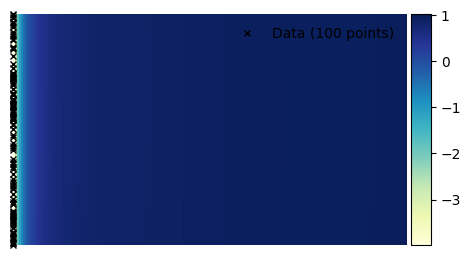

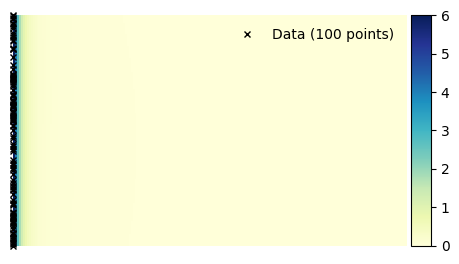

Tempo de treinamento: 168.8474


In [ ]:
class PhysicsInformedNN:
    
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub, epoch_1, t_print, t_clear, xF, uF, vF):
        
        X0 = np.concatenate((x0, 0*x0), 1)
        XF = np.concatenate((xF, 0*x0+1000), 1) #A posição das condições finais deve ser também adicionada aqui
        X_lb = np.concatenate((0*tb + lb[0], tb), 1)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1)

        #Variáveis:
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.xF = XF[:,0:1]
        self.tF = XF[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        self.v0 = v0

        self.uF = uF
        self.vF = vF

        self.t_print = t_print
        self.t_clear = t_clear

        self.epoch_1 = epoch_1

        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        #Tf placeholders:        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])

        self.xF_tf = tf.placeholder(tf.float32, shape=[None, self.xF.shape[1]])
        self.tF_tf = tf.placeholder(tf.float32, shape=[None, self.tF.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])

        self.uF_tf = tf.placeholder(tf.float32, shape=[None, self.uF.shape[1]])
        self.vF_tf = tf.placeholder(tf.float32, shape=[None, self.vF.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        #Tf graphs:
        self.u0_pred, self.v0_pred, _ , _ = self.net_uv(self.x0_tf, self.t0_tf)
        self.uF_pred, self.vF_pred, _ , _ = self.net_uv(self.xF_tf, self.tF_tf)
        self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        
        self.f_u_pred_01, self.f_v_pred_01 = self.net_f_uv_01(self.x_f_tf, self.t_f_tf)

        #Loss sem condições finais:
        self.loss_01 = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                       tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                       tf.reduce_mean(tf.square(self.f_u_pred_01)) + \
                       tf.reduce_mean(tf.square(self.f_v_pred_01))   
                   
        '''
        #Loss com condições finais:               
        self.loss_01 = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \ 
                       tf.reduce_mean(tf.square(self.uF_tf - self.uF_pred)) + \
                       tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                       tf.reduce_mean(tf.square(self.vF_tf - self.vF_pred)) + \ 
                       tf.reduce_mean(tf.square(self.f_u_pred_03)) + \
                       tf.reduce_mean(tf.square(self.f_v_pred_03))

        #Loss com condições finais e sem as condições da derivada:
        self.loss_01 = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                       tf.reduce_mean(tf.square(self.uF_tf - self.uF_pred)) + \
                       tf.reduce_mean(tf.square(self.f_u_pred_02)) + \
                       tf.reduce_mean(tf.square(self.f_v_pred_02))
        '''

        #Otimizador (LBFGSB):
        self.optimizer_01 = dde.optimizers.tensorflow_compat_v1.scipy_optimizer.ScipyOptimizerInterface(self.loss_01,
                                                                                                        method = 'L-BFGS-B', 
                                                                                                        options = {'maxiter': epoch_1,
                                                                                                                   'maxfun': 50000,
                                                                                                                   'maxcor': 50,
                                                                                                                   'maxls': 50,
                                                                                                                   'ftol': 1.0 * np.finfo(float).eps})
        
        #Otimizador (ADAM):
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam_01 = self.optimizer_Adam.minimize(self.loss_01)

        #Tf session:
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
                
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
      
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv_01(self, x, t):

        u, v, u_x, v_x = self.net_uv(x,t)

        u_t = tf.gradients(u, t)[0]
        v_t = tf.gradients(v, t)[0]
        
        #Definir equações a serem resolvidas:
        b=1
        f_v = u_t - v
        f_u = -(t**2+b**2)*v_t + 2*u - 2

        return f_u, f_v

    def callback(self, loss):
        
        global epoch
        global min_loss_save

        epoch+=1

        if epoch % t_print == 0:
            print('Epoch:', epoch, 'Loss:', loss)
            tmp = 0.

        if epoch % t_clear == 0:
            output.clear()
        
    def train(self, nIter, repetition):

        global epoch
        global min_loss_save

        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.xF_tf: self.xF, self.tF_tf: self.tF,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.uF_tf: self.uF, self.vF_tf: self.vF,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}

        for i in range(repetition):

            #Treino do ADAM:
            start_time = time.time()
            for it in range(nIter):
                
                self.sess.run(self.train_op_Adam_01, tf_dict)
                epoch+=1
                
                if it % t_print == 0:
                    elapsed = time.time() - start_time
                    loss_value = self.sess.run(self.loss_01, tf_dict)
                    print('It: %d, Loss: %.3e, Time: %.2f'%(epoch, loss_value, elapsed))      
                    start_time = time.time()
                
                if epoch % t_clear == 0:
                    output.clear()
            
            #Treino do LBFGSB:
            self.optimizer_01.minimize(self.sess, 
                                    feed_dict = tf_dict,         
                                    fetches = [self.loss_01], 
                                    loss_callback = self.callback)

            model.plot_min_01()
    
    def predict_01(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred_01, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred_01, tf_dict)
               
        return u_star, v_star, f_u_star, f_v_star

    def plot_min_01(self):

        u_pred, v_pred, f_u_pred, f_v_pred = model.predict_01(X_star)
        hu_pred = u_pred

        HU_pred = griddata(X_star, hu_pred.flatten(), (X, T), method='cubic')

        X0 = np.concatenate((x0, 0*x0), 1)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1)
        X_u_train = np.vstack([X0, X_lb, X_ub])

        fig, ax = newfig(1.0, 0.9)
        ax.axis('off') 
    
        h = ax.imshow(HU_pred.T, interpolation='nearest', cmap='YlGnBu', 
                    extent=[lb[1], ub[1], lb[0], ub[0]], 
                    origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(h, cax=cax)
    
        ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)
    
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        leg = ax.legend(frameon=False, loc = 'best')

        hv_pred = v_pred

        HV_pred = griddata(X_star, hv_pred.flatten(), (X, T), method='cubic')

        X0 = np.concatenate((x0, 0*x0), 1)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1)
        X_u_train = np.vstack([X0, X_lb, X_ub])

        fig, ax = newfig(1.0, 0.9)
        ax.axis('off')
    
        h = ax.imshow(HV_pred.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(h, cax=cax)
    
        ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)
    
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        leg = ax.legend(frameon=False, loc = 'best')

        plt.show()

if __name__ == "__main__": 
    
    epoch_1 = 3000 #Épocas do LBFGSB
    epoch_2 = 3000 #Épocas do ADAM

    t_print = epoch_1/300 #Printar loss a cada t_print épocas
    t_clear = 100000000000 #Limpar os logs a cada t_clear épocas
    epoch = 0 #Variável para o contador de épocas do ADAM
    repetition = 1 #Quantas vezes o loop de treino ADAM/LBFGS será repetido
    
    #Domínio onde as equações serão resolvidas
    lb = np.array([-1.0, 0.0]) #[x_min, t_min]
    ub = np.array([1.0, 50]) #[x_max, t_max]

    #Quantidade de pontos a serem utilizados para treino:
    N0 = 100 #Número de pontos nas cond. iniciais
    N_b = 0 #Número de pontos nas cond. de contorno
    NF = 100 #Número de pontos nas cond. finais
    N_f = 20000 #Número de pontos para cálculo do resíduo

    layers = [2, 200, 200, 200, 200, 200, 2] #Neurônios e camadas

    data = scipy.io.loadmat('dataset.mat')  #Importar dataset

    t = data['t'].flatten()[:,None]   #Esta lista representará a coordenada rho em nosso problema
    x = data['x'].flatten()[:,None]   #Esta lista representará uma coordanada fictícia em nosso problema
    Exact = data['u'] #Solução exata, caso tenha sido adicionada ao dataset, para fins de comparação

    #Pré-processamento do dataset:
    Exact_u = np.real(Exact)
    Exact_v = np.imag(Exact)
    Exact_h = Exact_u
    
    X, T = np.meshgrid(x,t)
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact_u.T.flatten()[:,None]
    v_star = Exact_v.T.flatten()[:,None]
    h_star = Exact_h.T.flatten()[:,None]
   
    idx_x = np.random.choice(x.shape[0], N0, replace=False)
    x0 = x[idx_x,:] 
    u0 = Exact_u[idx_x,0:1]  
    v0 = Exact_v[idx_x,0:1] 
    
    idx_x = np.random.choice(x.shape[0], NF, replace=False)  
    xF = x[idx_x,:] 
    uF = Exact_u[idx_x,t_dim-1:t_dim]  
    vF = Exact_v[idx_x,t_dim-1:t_dim] 

    idx_t = np.random.choice(t.shape[0], N_b, replace=False) 
    tb = t[idx_t,:] 
    
    X_f = lb + (ub-lb)*lhs(2, N_f)
    
    #Iniciar treino:
    start_time = time.time() 

    model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, epoch_1, t_print, t_clear, xF, uF, vF)
    model.train(epoch_2, repetition)

    print('Tempo de treinamento: %.4f' % (time.time() - start_time))


Calcular a posição do horizonte de eventos:

In [ ]:
from scipy import optimize

def func(index):
    list_tmp = np.array([0., index])
    list_tmp2 = list_tmp.reshape(1,2)
    final_list = model.predict_01(list_tmp2)
    return final_list[0][0][0]

root = optimize.brentq(func, 0, 3)
print(root)


1.8906602263438494


Calcular erro (MAE):

In [ ]:
lista_erros = []
tmp_list_1 = [-(3*np.pi)/(2)-(3*np.pi*rho**2)/(2)+(1)/(1+rho**2)+(3*rho)/(1+rho**2)+(rho**2)/(1+rho**2)+(3*rho**3)/(1+rho**2)+(3*np.arctan(rho))/(1)+(3*np.arctan(rho)*rho**2)/(1) for rho in t]
for i in range(len(t)):
    lista_erros.append(abs(tmp_list_1[i]-func(t[i])))
print(np.mean(lista_erros))


<ipython-input-9-5acbb97ed805>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list_tmp = np.array([0., index])


0.013019614339130936


Gráfico final:

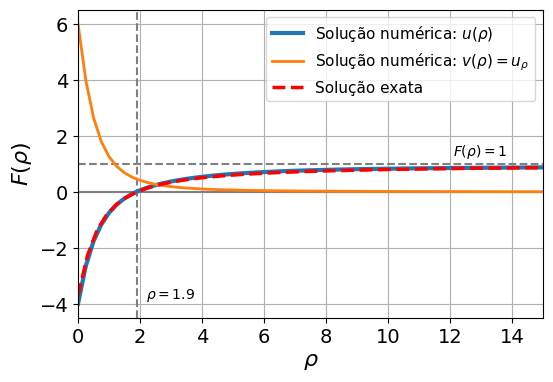

In [ ]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict_01(X_star)

hu_pred = u_pred
HU_pred = griddata(X_star, hu_pred.flatten(), (X, T), method='cubic')

hv_pred = v_pred
HV_pred = griddata(X_star, hv_pred.flatten(), (X, T), method='cubic')

X0 = np.concatenate((x0, 0*x0), 1)
X_lb = np.concatenate((0*tb + lb[0], tb), 1)
X_ub = np.concatenate((0*tb + ub[0], tb), 1)
X_u_train = np.vstack([X0, X_lb, X_ub])


fig, ax = plt.subplots(figsize=(6,4))
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=1.9, color='gray', linestyle='--')
plt.axhline(y=1., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='-')
plt.plot(t, HU_pred[:,0], '-', linewidth = 3, label=r'Solução numérica: $u(\rho)$')
plt.plot(t, HV_pred[:,0], '-', linewidth = 2, label=r'Solução numérica: $v(\rho)=u_\rho$')
plt.text(12.1, 1.3, r'$F(\rho)=1$')
plt.text(2.2, -3.8, r'$\rho=1.9$')
plt.plot(np.linspace(0.0, 15, num=50), 
         [-(3*np.pi)/(2)-(3*np.pi*rho**2)/(2)+(1)/(1+rho**2)+(3*rho)/(1+rho**2)+(rho**2)/(1+rho**2)+(3*rho**3)/(1+rho**2)+(3*np.arctan(rho))/(1)+(3*np.arctan(rho)*rho**2)/(1) for rho in np.linspace(0., 15., num=50)], 
         'r--', linewidth = 2.5, label='Solução exata')
ax.set_xlim(0, 15)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$F(\rho)$')
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.legend(loc='upper right', prop={'size': 11})
plt.show()
